In [1]:
import pandas as pd
import numpy as np
from bff_processor.Systogram import Systogram
from bff_processor.bff_meta import *
from bff_processor.sig_op_func import *
from bff_processor.bff_cuts import bff_1, bff_2, reg_filter
from bff_processor.plotting_utils import unc_plot, boost2unc
from bff_processor.utils import nratio_plot_template, hist2unc, vunc2nom, chiSquared, color_map
import os
import re
from time import perf_counter
import boost_histogram as bh
import pyarrow.feather as feather
import zfit
from zfit import z
from math import pi
import mplhep as hep
hep.style.use(hep.style.CMS)
plt.rcParams.update({
    "text.usetex": True,
})
from zfit.models.physics import DoubleCB

/home/ryan/Develop/Physics/env/lib/python3.8/site-packages/zfit/__init__.py:37: UserWarning: TensorFlow warnings are by default suppressed by zfit. In order to show them, set the environment variable ZFIT_DISABLE_TF_WARNINGS=0. In order to suppress the TensorFlow warnings AND this warning, set ZFIT_DISABLE_TF_WARNINGS=1.
  warnings.warn("TensorFlow warnings are by default suppressed by zfit."


In [2]:
import pickle

In [3]:
try:
    mu = zfit.Parameter("mu", 300,  100, 600)
    sigma = zfit.Parameter("sigma", 20,  0, 100)
    alphal = zfit.Parameter("alphal", 2,  0, 100)
    nl = zfit.Parameter("nl", 3,  -10, 10)
    alphar = zfit.Parameter("alphar", 1.5,  0, 100)
    nr = zfit.Parameter("nr", 6,  -100, 100)
    Nsig = zfit.Parameter("Nsig", 1., -20., 1e8)
except:
    print("already defined")

In [4]:
x_range = [110,800]
obs = zfit.Space("x", limits=x_range)

In [5]:
era = '16-18'
#era = '2016'
if era=='2016':
    lumi=35.50
    nl_array = [2.86,2.67]
if era=='2017':
    lumi=41.85
if era=='2018':
    lumi=58.88
if era=='16-18':
    lumi = 35.5+41.85+58.88
    df = feather.read_feather('data/combined_2016.feather'.format(era))
    print(df.shape)
    df = df.append( feather.read_feather('data/combined_2017.feather'.format(era)))
    print(df.shape)
    df = df.append( feather.read_feather('data/combined_2018.feather'.format(era)))
    print(df.shape)
    print("loaded all df")
else:
    df = feather.read_feather('data/combined_{}.feather'.format(era))

(1602844, 106)
(3166251, 116)
(5083468, 116)
loaded all df


In [6]:
bff_data = df[df.name.str.contains("BFF")]
df  = bff_data[(bff_data.DiLepMass > x_range[0]) & (bff_data.DiLepMass < x_range[1]) & (bff_data.dbs==0.04)]
masses = df.mass.unique()
masses = sorted(masses)
masses

[125.0, 150.0, 175.0, 200.0, 250.0, 300.0, 350.0, 400.0, 450.0, 500.0]

In [7]:
def reset_params(data):
    mean = np.mean(data)
    std = np.std(data)
    mu.set_value(mean)
    sigma.set_value(std)
    alphal.set_value(2)
    nl.set_value(3)
    alphar.set_value(1.5)
    nr.set_value(6)

In [8]:
def scaled_pdf(pdf, x, sumW, obs):
        y = pdf(x)
        n_bins = len(x)
        plot_scaling = sumW / n_bins * obs.area()
        return (y * plot_scaling).numpy()

In [20]:
param_list = []
plot_dict = {}
compute_hesse = False
regions = ["SR1", "SR2"]
regions = ["Both"]
for reg in regions:
    plot_dict[reg] = {}
    for mass in masses:
        print(mass)
        if reg == "Both":
            tdf = df[(df.mass==mass)]
        else:
            tdf = df[(df.mass==mass) & (df[reg+'_nom']==1)]
        data, weights = tdf.DiLepMass.to_numpy(),tdf.Weight.to_numpy()
        reset_params(data)
        
        doublecb = DoubleCB(obs=obs, mu=mu, sigma=sigma,
                         alphal=1.38, nl=2.42, 
                         alphar=1.8, nr=nr)
        
        #set up fit
        data_zfit = zfit.Data.from_numpy(obs=obs, array=data, weights=weights)
        nll = zfit.loss.UnbinnedNLL(model=doublecb, data=data_zfit)
        minimizer = zfit.minimize.Minuit()
        result = minimizer.minimize(nll)
        if compute_hesse:
            x = result.hesse()
        else:
            x = {}
        param_dict = {'reg': reg, 'mass': mass, **{p.name:p.value().numpy() for p in result.params}, **{p.name+"_error":x[p]['error'] for p in x}}
        param_list.append(param_dict)
        
        #make the plot
        bins = np.linspace(*x_range, int((x_range[1]-x_range[0])/2 + 1))
        bin_centers = [(bins[i]+bins[i+1])/2 for i in range(len(bins) - 1)]
        y = scaled_pdf(doublecb.pdf, bin_centers, np.sum(weights), obs)
        hist, _ = np.histogram(data, weights=weights, bins=bins)
        hist_var, _ = np.histogram(data, weights=weights **2 , bins=bins)
        hist_std = hist_var ** .5
        
        plot_dict[reg][mass] = {"fit": y, "hist": hist, "hist_std": hist_std}

125.0
150.0
175.0
200.0
250.0
300.0
350.0
400.0
450.0
500.0


In [21]:
pdf = pd.DataFrame(param_list)
pdf

,reg,mass,mu,nr,sigma
0,Both,125.0,124.967620,3.534521,1.566289
1,Both,150.0,149.910196,3.784796,1.995597
2,Both,175.0,174.798644,4.362585,2.490107
3,Both,200.0,199.716851,4.565900,3.036378
4,Both,250.0,249.521429,4.827405,4.177152
5,Both,300.0,299.339143,5.267003,5.479787
6,Both,350.0,349.076770,5.502443,6.928814
7,Both,400.0,398.842343,6.631523,8.338600
8,Both,450.0,448.506104,7.139859,9.733797
9,Both,500.0,498.390571,8.541000,11.195724


In [22]:
if compute_hesse: pdf.to_csv('fits/bff/bff_{}.csv'.format(era))

In [23]:
def chi2(xm, xp, error, ndf=0):
    y = (xm - xp) ** 2 / error **2
    return np.sum(y)/(len(y) - ndf)

[]


/tmp/ipykernel_1092776/3409189232.py:25: RuntimeWarning: divide by zero encountered in true_divide
  bottom.plot(bin_centers, fit_plot/hist, color=color)
/tmp/ipykernel_1092776/3409189232.py:25: RuntimeWarning: divide by zero encountered in true_divide
  bottom.plot(bin_centers, fit_plot/hist, color=color)
/tmp/ipykernel_1092776/3409189232.py:25: RuntimeWarning: divide by zero encountered in true_divide
  bottom.plot(bin_centers, fit_plot/hist, color=color)
/tmp/ipykernel_1092776/3409189232.py:25: RuntimeWarning: divide by zero encountered in true_divide
  bottom.plot(bin_centers, fit_plot/hist, color=color)
/tmp/ipykernel_1092776/3409189232.py:25: RuntimeWarning: divide by zero encountered in true_divide
  bottom.plot(bin_centers, fit_plot/hist, color=color)
/tmp/ipykernel_1092776/3409189232.py:25: RuntimeWarning: divide by zero encountered in true_divide
  bottom.plot(bin_centers, fit_plot/hist, color=color)
/tmp/ipykernel_1092776/3409189232.py:25: RuntimeWarning: divide by zero enco

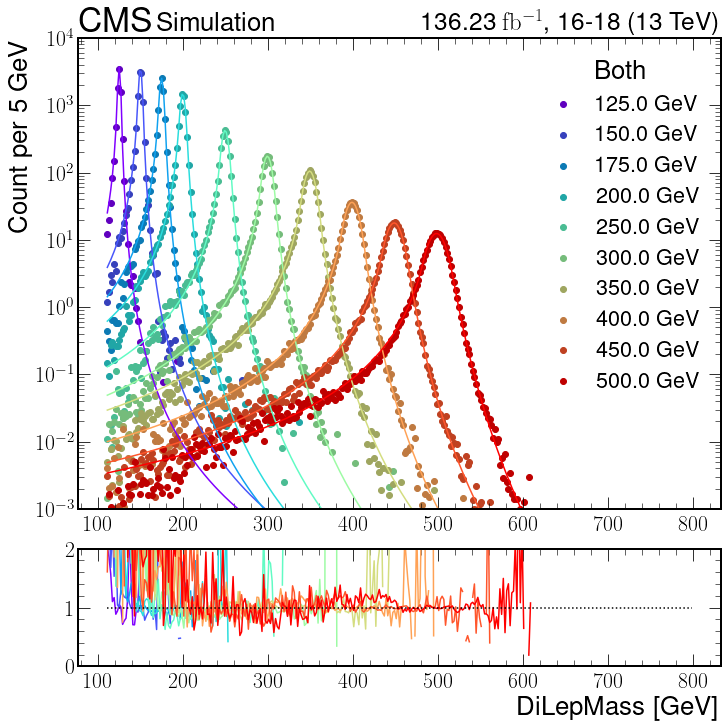

In [24]:
colors = color_map(len(masses))
for reg, reg_dict in plot_dict.items():
    fig, ax = nratio_plot_template(nPlots=[1,1])
    (top, bottom) = ax[0][0]
    for color, (mass, mass_dict) in zip(colors,reg_dict.items()):
        #make a different color for histogram
        hist_color = np.power(color, 1)*.75
        #set alpha
        hist_color[-1] = 1

        fit_plot = mass_dict['fit']
        hist = mass_dict['hist']
        hist_std = mass_dict['hist_std']
        
        #def filter out 0 values:
        hist_filt = hist[hist!=0]
        hist_std_filt = hist_std[hist!=0]
        fit_plot_filt = fit_plot[hist!=0]
        pdf.loc[(pdf.mass==mass) & (pdf.reg==reg), 'chi2'] = chi2(fit_plot_filt, hist_filt, hist_std_filt, ndf=1)
        
        
        top.scatter(bin_centers, hist, label='{} GeV'.format( mass), color=hist_color)
        top.plot(bin_centers, fit_plot, color=color)
        
        bottom.plot(bin_centers, fit_plot/hist, color=color)
    top.legend(title=reg)
    top.set_yscale('log')
    top.set_ylim(bottom=.1e-2,top=1e4)
    bottom.set_ylim(bottom=0, top=2)
    bottom.plot(bin_centers, np.full(len(bin_centers), 1), color='black', linestyle=':')
    bottom.set_xlabel('DiLepMass [GeV]')
    top.set_ylabel('Count per 5 GeV')
    hep.cms.label(loc=0,ax=top,lumi=lumi,year=era, data=False)
    if compute_hesse:
        fig.savefig('fits/bff/bff_{}_{}.png'.format(reg, era))
    else:
        fig.savefig('fits/bff/bff_{}_{}_nohess.png'.format(era, reg))

In [25]:
pdf

,reg,mass,mu,nr,sigma,chi2
0,Both,125.0,124.967620,3.534521,1.566289,12.179045
1,Both,150.0,149.910196,3.784796,1.995597,8.332109
2,Both,175.0,174.798644,4.362585,2.490107,9.165203
3,Both,200.0,199.716851,4.565900,3.036378,19.758256
4,Both,250.0,249.521429,4.827405,4.177152,13.095097
5,Both,300.0,299.339143,5.267003,5.479787,32.012073
6,Both,350.0,349.076770,5.502443,6.928814,7.206496
7,Both,400.0,398.842343,6.631523,8.338600,219.642986
8,Both,450.0,448.506104,7.139859,9.733797,2.676841
9,Both,500.0,498.390571,8.541000,11.195724,3.578639


In [26]:
def gs_plot(xrange, yrange, **kwargs):
    fig = plt.figure(constrained_layout=True, **kwargs)
    gs = fig.add_gridspec(xrange,yrange)
    for x in range(xrange):
        for y in range(yrange):
            fig.add_subplot(gs[x,y])
    return fig

In [27]:
from scipy.optimize import curve_fit

In [28]:
def constant(x, b):
    return linear(x, b, 0)

def linear(x, b, m):
    return m * x + b

def quad(x, b, m, m2):
    return m2 * x ** 2 + m * x + b

def pol4(x, b, m, m2, m3):
    return m3 * x**3 + m2 * x ** 2 + m * x + b

mu [0.57839198 0.99561578]


/tmp/ipykernel_1092776/3652419741.py:33: RuntimeWarning: invalid value encountered in sqrt
  print(pcov**.5)


[[0.04298323        nan]
 [       nan 0.00013618]]
nr [1.99831802 0.01178409]


/tmp/ipykernel_1092776/3652419741.py:33: RuntimeWarning: invalid value encountered in sqrt
  print(pcov**.5)


[[0.29232329        nan]
 [       nan 0.00092615]]
sigma [ 3.17366778e-01  2.83953748e-03  6.36814897e-05 -5.18035850e-08]


/tmp/ipykernel_1092776/3652419741.py:33: RuntimeWarning: invalid value encountered in sqrt
  print(pcov**.5)


[[1.64673737e-01            nan 1.01325360e-03            nan]
 [           nan 1.87871817e-03            nan 3.54157559e-06]
 [1.01325360e-03            nan 6.46044582e-06            nan]
 [           nan 3.54157559e-06            nan 6.85693308e-09]]


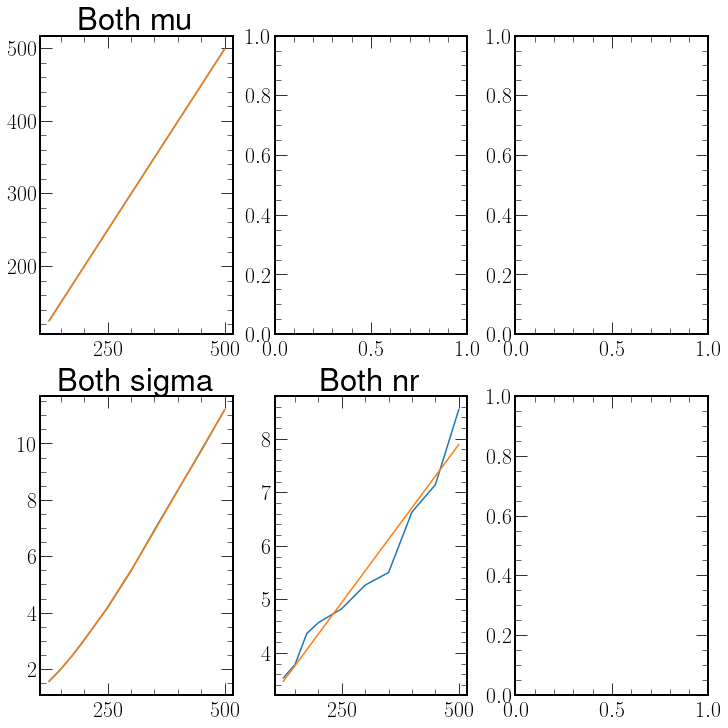

In [29]:
params = ["alphal" ,"alphar" ,"mu","nl" ,"nr" ,"sigma"]
indicies =  [2,5,0,1,4,3]
funcs =[linear,linear,linear,constant,linear,pol4]
for reg in pdf.reg.unique():
    tdf = pdf[pdf.reg==reg]
    x = tdf.mass.to_numpy()
    fig = gs_plot(2,3) 
    for index, par, func in zip(indicies, params, funcs):
        axes = fig.axes[index]
        try:
            y = tdf[par].to_numpy()
        except:
            continue
        if compute_hesse:
            yerr = tdf[par+"_error"].to_numpy()
            axes.errorbar(x, y, yerr=yerr)
        else:
            axes.plot(x, y)
        axes.set_title(reg + " " + par)
        
        # best fit
        # cut left bins on left side
        if par in ['nl', 'alphal']:
            y = y[x>x_range[0]+50]
            xplot = x[x>x_range[0]+50]
        else:
            xplot = x
        popt,pcov = curve_fit(func, xplot, y)
        fit_y = func(xplot, *popt)
        axes.plot(xplot, fit_y)
        
        print(par, popt)
        print(pcov**.5)
    if compute_hesse:
        fig.savefig('fits/bff/params_{}_{}.png'.format(era, reg, par))
    else:
        fig.savefig('fits/bff/params_{}_{}_nohess.png'.format(era, reg, par))

In [30]:
#2016:
alphal:1.38
nl:2.53 +- .01753185
alphar: 1.67 +- 0.03805059
    